# Metodología

# Implementación

Para ubicar óptimamente microplantas de digestión anaerobia en Bogotá, combinamos análisis geoespacial (con redes viales, áreas restringidas, viento, colegios) con modelos clásicos de localización (p-median, Weber, cobertura). Usamos Python, cargando los datos base: shapefiles de localidades, red vial, rondas hídricas/inundaciones (desde el Geoportal de Bogotá
visorgeo.ambientebogota.gov.co
), dirección predominante del viento, y localización de colegios públicos. Además incorporamos los datos de poda anual por ASE 1–5 (toneladas/mes), proporcionados por UAESP. El proceso incluye limpieza de datos, análisis exploratorio por operadora, georreferenciación de zonas de poda, generación de superficies de densidad de biomasa y finalmente la optimización de la ubicación. El objetivo es ubicar una (o varias) plantas en cada zona operativa minimizando la distancia a los colegios del área, respetando restricciones ambientales y maximizando accesibilidad vial.

A continuación se realiza la instalación de la librería PuLP para resolver problemas de programación lineal.

In [ ]:
!pip install pulp

A continuación se realiza la importación de las librerías necesarias para el manejo de datos, análisis espacial, visualización y optimización:

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
import networkx as nx
import pulp # Para optimización (p-median o cobertura)
%matplotlib inline

A continuación se realiza la carga de los archivos necesarios al entorno de Google Colab, específicamente: ronda_hidraulica.gpkg, Bogota.gpkg, data-set-octubre-2025.xlsx, Matricula.gpkg, Colegios.gpkg, amenaza_in_desbordamiento.gpkg, sistemahidrico.gpkg y amenaza_mm.gpkg, los cuales contienen la información espacial, de amenaza y de datos tabulares requerida para el análisis.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving data-set-octubre-2025.xlsx to data-set-octubre-2025.xlsx


Verificamos que efectivamente se cargaron los archivos.

In [ ]:
# Lista los archivos en el directorio actual
# ['.config',
#  'ronda_hidraulica.gpkg',
#  'Bogota.gpkg',
#  'data-set-octubre-2025.xlsx',
#  'Matricula.gpkg',
#  'Colegios.gpkg',
#  'amenaza_in_desbordamiento.gpkg',
#  'sistemahidrico.gpkg',
#  'amenaza_mm.gpkg',
#  'sample_data']
os.listdir()

['.config',
 'Bogota.gpkg',
 'ronda_hidraulica.gpkg',
 'Colegios.gpkg',
 'drive',
 'amenaza_mm.gpkg',
 'Matricula.gpkg',
 'amenaza_in_desbordamiento.gpkg',
 'data-set-octubre-2025.xlsx',
 'sistemahidrico.gpkg',
 'sample_data']

A continuación se realiza la lectura del archivo data-set-octubre-2025.xlsx, la limpieza de los nombres de las columnas, la identificación y estandarización de la columna correspondiente a las toneladas de poda, el renombramiento de campos clave (Operador, Mes, Toneladas), la creación de una columna de Zona asociada al operador, la eliminación de la fila de totales y, finalmente, la agregación de la información por operador y zona para obtener el total de toneladas de poda por cada uno.

In [ ]:
import pandas as pd

poda_df = pd.read_excel('data-set-octubre-2025.xlsx')

# Limpiar espacios en los nombres de columnas
poda_df.columns = poda_df.columns.str.strip()

# Localizar las columnas que nos interesan
col_cesped = [c for c in poda_df.columns if 'Corte Césped' in c][0]
col_poda   = [c for c in poda_df.columns if 'Poda Árboles' in c][0]

# Renombrar columnas a los nombres que quieres usar en el modelo
poda_df = poda_df.rename(columns={
    'ASE y Concesionario': 'Operador',
    'Año/Mes Formato (dd-mmm-yy)': 'Mes',
    col_cesped: 'Ton_cesped',
    col_poda:   'Ton_poda'
})

# Nos quedamos solo con las columnas relevantes
poda_df = poda_df[['Mes', 'Operador', 'Ton_cesped', 'Ton_poda']]

# Crear una columna Zona (si cada operador corresponde a una zona)
poda_df['Zona'] = poda_df['Operador']

# Eliminar la fila de totales (la que dice "Total Toneladas (t/mes)")
poda_df = poda_df[~poda_df['Operador'].astype(str).str.contains('Total', case=False, na=False)]

# (Opcional) agrupar por operador y zona, manteniendo las dos columnas separadas
poda_grouped = poda_df.groupby(['Operador', 'Zona'], as_index=False)[['Ton_cesped', 'Ton_poda']].sum()

print(poda_grouped.head())

               Operador                  Zona  Ton_cesped  Ton_poda
0  ASE 1 Promoambiental  ASE 1 Promoambiental      233.42     95.63
1  ASE 2 LIME S.A E.S.P  ASE 2 LIME S.A E.S.P      273.21     93.63
2   ASE 3 CIUDAD LIMPIA   ASE 3 CIUDAD LIMPIA      147.74     92.13
3   ASE 4 BOGOTÁ LIMPIA   ASE 4 BOGOTÁ LIMPIA      139.58     89.06
4     ASE 5 ÁREA LIMPIA     ASE 5 ÁREA LIMPIA      126.46     88.84


In [ ]:
poda_grouped['Toneladas'] = poda_grouped['Ton_cesped'] + poda_grouped['Ton_poda']
print(poda_grouped['Toneladas'])

0    329.05
1    366.84
2    239.87
3    228.64
4    215.30
Name: Toneladas, dtype: float64


En esta etapa se consolidan los datos de poda total por zona de cada ASE, se verifica la consistencia de la información (por ejemplo, ausencia de valores faltantes o registros de totales y duplicados) y se transforman las columnas relevantes a formato numérico y con nombres estandarizados, lo que permite comparar la biomasa disponible por área operacional de cada empresa operadora. Dado que no se cuenta con una caracterización directa de los residuos (fracción biodegradable y fracción impropia), se adopta un escenario de referencia en el cual se asume que el 90 % de los residuos de poda corresponde a fracción biodegradable y el 10 % a fracción impropia, incluyendo además un rango de incertidumbre entre 85 % y 95 % para la fracción biodegradable. Con estos supuestos se estiman, para cada operador y zona, las toneladas biodegradables e impropias, así como los valores mínimo y máximo de biomasa biodegradable esperada.

In [ ]:
# Sumar corte césped + poda de árboles
poda_grouped['Toneladas'] = poda_grouped['Ton_cesped'] + poda_grouped['Ton_poda']

# - Residuos de poda urbana son principalmente biomasa vegetal.
# - Tomamos un escenario medio de 90 % biodegradable, 10 % impropios.
FRACCION_BIO = 0.90
FRACCION_IMPROPIA = 0.10

# Si quieres también un rango de incertidumbre:
FRACCION_BIO_MIN = 0.85
FRACCION_BIO_MAX = 0.95

# Estimación puntual
poda_grouped['Ton_biodegradable'] = poda_grouped['Toneladas'] * FRACCION_BIO
poda_grouped['Ton_impropia']      = poda_grouped['Toneladas'] * FRACCION_IMPROPIA

# (Opcional) Rango de incertidumbre para la fracción biodegradable
poda_grouped['Ton_bio_min'] = poda_grouped['Toneladas'] * FRACCION_BIO_MIN
poda_grouped['Ton_bio_max'] = poda_grouped['Toneladas'] * FRACCION_BIO_MAX

print("\nTabla con caracterización estimada de la poda (césped + poda de árboles):")
print(poda_grouped)


Tabla con caracterización estimada de la poda (césped + poda de árboles):
               Operador                  Zona  Ton_cesped  Ton_poda  \
0  ASE 1 Promoambiental  ASE 1 Promoambiental      233.42     95.63   
1  ASE 2 LIME S.A E.S.P  ASE 2 LIME S.A E.S.P      273.21     93.63   
2   ASE 3 CIUDAD LIMPIA   ASE 3 CIUDAD LIMPIA      147.74     92.13   
3   ASE 4 BOGOTÁ LIMPIA   ASE 4 BOGOTÁ LIMPIA      139.58     89.06   
4     ASE 5 ÁREA LIMPIA     ASE 5 ÁREA LIMPIA      126.46     88.84   

   Toneladas  Ton_biodegradable  Ton_impropia  Ton_bio_min  Ton_bio_max  
0     329.05            296.145        32.905     279.6925     312.5975  
1     366.84            330.156        36.684     311.8140     348.4980  
2     239.87            215.883        23.987     203.8895     227.8765  
3     228.64            205.776        22.864     194.3440     217.2080  
4     215.30            193.770        21.530     183.0050     204.5350  


Estimación preliminar del potencial energético de las podas urbanas

````markdown
A partir de la tabla agregada de poda por operador:

```text
Operador                  Toneladas totales   Ton_biodegradable   Ton_bio_min   Ton_bio_max
ASE 1 Promoambiental             329.05            296.15           279.69        312.60
ASE 2 LIME S.A E.S.P             366.84            330.16           311.81        348.50
ASE 3 CIUDAD LIMPIA              239.87            215.88           203.89        227.88
ASE 4 BOGOTÁ LIMPIA              228.64            205.78           194.34        217.21
ASE 5 ÁREA LIMPIA                215.30            193.77           183.00        204.53
------------------------------------------------------------------------------------------
TOTAL                           1379.70           1241.73          1172.74       1310.72   (t/mes aprox.)
````

trabajamos con la fracción biodegradable mensual total:

* Valor central:
  $B \approx 1242\ \text{t/mes}$
* Rango de incertidumbre:
  $B_{\min} \approx 1173\ \text{t/mes}, \qquad
  B_{\max} \approx 1311\ \text{t/mes}$

donde (B) representa las toneladas mensuales de poda (césped + poda de árboles) efectivamente biodegradables (sin impropios).

---

#### Hipótesis de conversión (basadas en literatura)

Para estimar el potencial de biogás se adoptan supuestos típicos para podas y residuos verdes urbanos:

1. **Contenido de sólidos totales (TS)** en podas urbanas:
   $TS \approx 50% \text{ de la masa fresca}$
   dentro del rango 40–60 % reportado para residuos verdes y de poda. Estudios de valorización energética de podas urbanas usan valores similares al evaluar el potencial energético de estos residuos (Maccarini et al., 2020).([ScienceDirect][1])
   En paralelo, caracterizaciones recientes de biorresiduos urbanos en Europa muestran TS entre ≈40–60 % y fracciones de impropios en el orden de 10–20 % en flujos mal separados (Kostecki et al., 2023).([ouci.dntb.gov.ua][2])

2. **Fracción de sólidos volátiles (SV) sobre TS**:
   $\frac{SV}{TS} \approx 0.8 \quad (80%)$
   dentro del intervalo 60–90 % observado para residuos orgánicos lignocelulósicos y biorresiduos urbanos en plantas de digestión a escala real (Holliger et al., 2017).([ResearchGate][3])

3. **Rendimiento de biogás por tonelada de SV**:
   $Y_{\text{biogás}} \approx 200\ \text{m}^3/\text{tSV}$
   valor medio conservador dentro del rango aproximado 180–300 m³ biogás/tSV reportado para residuos verdes urbanos y mezclas de poda con otros sustratos (Maccarini et al., 2020; Holliger et al., 2017).([ScienceDirect][1])

4. **Fracción de metano en el biogás**:
   $x_{\text{CH}_4} \approx 60%$
   consistente con composiciones típicas de biogás (50–70 % CH₄) para residuos orgánicos urbanos.([Wikipedia][4])

5. **Poder calorífico inferior del metano**:
   $PCI_{\text{CH}_4} \approx 35.8\ \text{MJ/m}^3$
   valor estándar citado en manuales y fichas técnicas de biogás.([Wikipedia][4])

6. **Eficiencias de conversión en un sistema de cogeneración (CHP)**:

   * Rendimiento eléctrico: $\eta_e \approx 35%$
   * Rendimiento térmico útil: $\eta_t \approx 45%$

   Valores coherentes con motores de cogeneración a biogás reportados en la literatura y fichas técnicas de fabricantes (véase p.ej. compilaciones de plantas en Holliger et al., 2017).([ResearchGate][3])

---

#### Cálculo paso a paso (valor central)

1. **Sólidos totales (TS)** a partir de la fracción biodegradable mensual $B$:

$TS = 0.5 \times B$

Para $B \approx 1241.73\ \text{t/mes}$:

$TS \approx 0.5 \times 1241.73 \approx 620.9\ \text{tTS/mes}$

2. **Sólidos volátiles (SV)**:

$SV = 0.8 \times TS \approx 0.8 \times 620.9 \approx 496.7\ \text{tSV/mes}$

3. **Producción de biogás**:

$V_{\text{biogás}} = SV \times Y_{\text{biogás}}$

$V_{\text{biogás}} \approx 496.7\ \text{tSV} \times 200\ \frac{\text{m}^3}{\text{tSV}}
\approx 99{,}300\ \text{m}^3/\text{mes}$

4. **Volumen de metano**:

$V_{\text{CH}*4} = x*{\text{CH}*4} \times V*{\text{biogás}}$

$V_{\text{CH}_4} \approx 0.6 \times 99{,}300 \approx 59{,}600\ \text{m}^3/\text{mes}$

5. **Energía química del metano**:

$E_{\text{química}} = V_{\text{CH}*4} \times PCI*{\text{CH}_4}$

$E_{\text{química}} \approx 59{,}600\ \text{m}^3 \times 35.8\ \frac{\text{MJ}}{\text{m}^3}
\approx 2.1 \times 10^6\ \text{MJ/mes}$

Conversión a MWh (recordando que $1\ \text{kWh} = 3.6\ \text{MJ})$:

$E_{\text{química}} \approx \frac{2.13 \times 10^6\ \text{MJ}}{3.6 \times 10^3\ \text{MJ/MWh}}
\approx 593\ \text{MWh/mes}$

6. **Energía eléctrica y térmica útil** (CHP, valor central):

* Energía eléctrica mensual:

$E_e = \eta_e \times E_{\text{química}}
\approx 0.35 \times 593 \approx 207\ \text{MWh}_e/\text{mes}$

* Energía térmica útil mensual:

$E_t = \eta_t \times E_{\text{química}}
\approx 0.45 \times 593 \approx 267\ \text{MWh}_t/\text{mes}$

Si se supone operación prácticamente continua $(\approx 30$ días/mes), la potencia media asociada sería:

* Potencia eléctrica media:

$\bar{P}_e \approx \frac{207\ \text{MWh}_e/\text{mes}}{30 \times 24\ \text{h}}
\approx 290\ \text{kW}_e$

* Potencia térmica media:

$\bar{P}_t \approx \frac{267\ \text{MWh}_t/\text{mes}}{30 \times 24\ \text{h}}
\approx 370\ \text{kW}_t$

---

#### Rango de incertidumbre (usando $B_{\min}) y (B_{\max})$

Repitiendo el cálculo con los extremos de la fracción biodegradable:

* Para $B_{\min} \approx 1172.74\ \text{t/mes}$:

  * $TS_{\min} \approx 586.4\ \text{tTS/mes}$
  * $SV_{\min} \approx 469.1\ \text{tSV/mes}$
  * $E_{\text{química},\min} \approx 560\ \text{MWh/mes}$
  * $E_{e,\min} \approx 196\ \text{MWh}_e/\text{mes}$
  * $E_{t,\min} \approx 252\ \text{MWh}_t/\text{mes}$

* Para $B_{\max} \approx 1310.72\ \text{t/mes}$:

  * $TS_{\max} \approx 655.4\ \text{tTS/mes}$
  * $SV_{\max} \approx 524.3\ \text{tSV/mes}$
  * $E_{\text{química},\max} \approx 626\ \text{MWh/mes}$
  * $E_{e,\max} \approx 219\ \text{MWh}_e/\text{mes}$
  * $E_{t,\max} \approx 282\ \text{MWh}_t/\text{mes}$

En términos de potencia media:

* Potencia eléctrica en el rango:
  $\bar{P}_e \approx 270\text{–}305\ \text{kW}_e$
* Potencia térmica en el rango:
  $\bar{P}_t \approx 350\text{–}390\ \text{kW}_t$

---

#### Lectura energética anual (orden de magnitud)

Si este flujo mensual de poda (césped + poda de árboles) se mantuviera de forma relativamente estable durante todo el año, el potencial anual sería del orden de:

* Energía química:
  $E_{\text{química,anual}} \approx 593 \times 12 \approx 7.1\ \text{GWh/año}$

* Electricidad útil:
  $E_{e,\text{anual}} \approx 207 \times 12 \approx 2.5\ \text{GWh}_e/\text{año}$

* Calor útil:
  $E_{t,\text{anual}} \approx 267 \times 12 \approx 3.2\ \text{GWh}_t/\text{año}$

Estos valores deben interpretarse como una **estimación preliminar** basada en parámetros medios de la literatura para podas y residuos verdes urbanos (Maccarini et al., 2020; Holliger et al., 2017; Kostecki et al., 2023).([ScienceDirect][1]) En etapas posteriores de la metodología, cuando se disponga de datos locales de caracterización (TS, SV, poder metanogénico y fracción de impropios), estos supuestos pueden refinarse y recalibrar el potencial energético estimado.

---

#### Enlaces directos a las referencias citadas

* Maccarini, A. C.; Bessa, M. R.; Errera, M. R. (2020). *Energy valuation of urban pruning residues: feasibility assessment*. Biomass and Bioenergy, 142, 105763.
  Disponible en: [https://doi.org/10.1016/j.biombioe.2020.105763](https://doi.org/10.1016/j.biombioe.2020.105763) ([ScienceDirect][1])

* Holliger, C. et al. (2017). *Methane production of full-scale anaerobic digestion plants: A survey on the current status in Europe*. Frontiers in Energy Research, 5, 12.
  Disponible en: [https://doi.org/10.3389/fenrg.2017.00012](https://doi.org/10.3389/fenrg.2017.00012) ([ResearchGate][3])

* Kostecki, J. et al. (2023). *Composition and selected properties of bio-waste collected in towns from single- and multi-family housing and in rural areas*. Waste Management, 172, 140–150.
  Disponible en: [https://doi.org/10.1016/j.wasman.2023.10.024](https://doi.org/10.1016/j.wasman.2023.10.024) ([ouci.dntb.gov.ua][2])

* Artículo de revisión sobre biogás (por ejemplo, entrada “Biogas” en Wikipedia, que compila intervalos típicos de composición y poderes caloríficos):
  [https://en.wikipedia.org/wiki/Biogas](https://en.wikipedia.org/wiki/Biogas) ([Wikipedia][4])

[1]: https://www.sciencedirect.com/science/article/abs/pii/S0956053X23006347.com "Composition and selected properties of bio-waste collected ..."
[2]: https://ouci.dntb.gov.ua/en/works/9j5nDKpl/?.com "Smart-Circular strategies for managing biomass resource ..."
[3]: https://www.researchgate.net/publication/318150627_Methane_Production_of_Full-Scale_Anaerobic_Digestion_Plants_Calculated_from_Substrate%27s_Biomethane_Potentials_Compares_Well_with_the_One_Measured_On-Site.com "Methane Production of Full-Scale Anaerobic Digestion ..."
[4]: https://en.wikipedia.org/wiki/Biogas.com "Biogas"

A continuación se carga el mapa de Bogotá que continiene las localidades.

In [ ]:
# Leer el archivo GeoPackage
gdf = gpd.read_file("Bogota.gpkg")
#print(gdf.head())


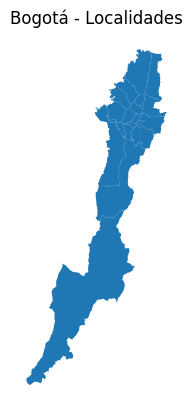

In [ ]:
# Graficar
gdf.plot()
plt.title("Bogotá - Localidades")
plt.axis("off")
plt.show()

En esta etapa se realiza la lectura de la capa de colegios distritales y su integración con el límite administrativo de Bogotá. Para ello, se armoniza el sistema de referencia de coordenadas (CRS) de ambas capas al sistema oficial adoptado para la ciudad (EPSG:3116) y se genera un mapa base donde se representan las localidades como polígonos y los colegios como puntos, permitiendo visualizar la distribución espacial de la infraestructura educativa en el territorio distrital.

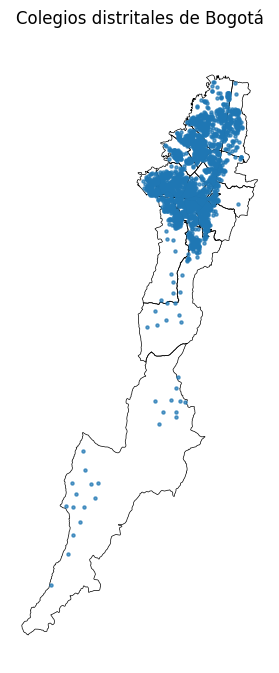

In [ ]:
colegios = gpd.read_file("Colegios.gpkg")

# gdf ya está cargado como Bogota.gpkg
localidades = gdf  # solo para usar un nombre más descriptivo

bogota_crs = "EPSG:3116"

# Asegurar que localidades y colegios estén en el mismo CRS
if localidades.crs and localidades.crs.to_string() != bogota_crs:
    localidades = localidades.to_crs(bogota_crs)

if colegios.crs and colegios.crs.to_string() != bogota_crs:
    colegios = colegios.to_crs(bogota_crs)

# Dibujar localidades + colegios
fig, ax = plt.subplots(figsize=(8, 8))

localidades.plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=0.5
)

colegios.plot(
    ax=ax,
    markersize=5,
    alpha=0.7
)

ax.set_title("Colegios distritales de Bogotá", fontsize=12)
ax.set_axis_off()

plt.show()

En esta etapa se incorpora la información de matrícula oficial a la capa de colegios distritales. Primero se lee el archivo Matricula.gpkg y se homogeneiza su sistema de referencia de coordenadas al usado en el análisis (EPSG:3116). Luego se identifican y verifican las columnas clave comunes entre las bases de colegios y matrícula, así como la columna que almacena el total de estudiantes (TMATRIC_GE). A partir de estas llaves se construye una tabla sin duplicados, se asegura que la matrícula esté en formato numérico y se realiza la unión con la capa de colegios. Con ello se define la variable de demanda, igual al número de estudiantes matriculados en cada institución (asignando valor cero cuando no hay dato) y, si es necesario, se generan las coordenadas x e y a partir de la geometría, preparando así la base para el modelado de demanda en el análisis de localización.

In [ ]:
matricula = gpd.read_file("Matricula.gpkg")

# Asegurar mismo CRS que venimos usando
bogota_crs = "EPSG:3116"
if matricula.crs and matricula.crs.to_string() != bogota_crs:
    matricula = matricula.to_crs(bogota_crs)

print("Columnas en 'matricula':")
print(matricula.columns)

# Columna de matrícula total (según tu head: TMATRIC_GE)
COL_MATRICULA = "TMATRIC_GE"

# Columnas llave para hacer el merge (ajusta si es necesario):
KEY_COLS = ["NOMBRE_EST", "NOMBRE_SED"]

# Verificamos qué llaves están realmente en ambos GeoDataFrames
common_keys = [c for c in KEY_COLS if c in colegios.columns and c in matricula.columns]
print("\nColumnas comunes usadas como llave:", common_keys)

if not common_keys:
    raise ValueError(
        "No hay columnas clave comunes entre 'colegios' y 'matricula'. "
        "Revisa colegios.columns y matricula.columns para definir KEY_COLS adecuadamente."
    )

# Nos quedamos solo con llaves + matrícula, sin duplicados ===
matricula_df = (
    matricula[common_keys + [COL_MATRICULA]]
    .drop_duplicates(subset=common_keys)
    .copy()
)

# Asegurar que la matrícula sea numérica
matricula_df[COL_MATRICULA] = pd.to_numeric(matricula_df[COL_MATRICULA], errors="coerce")

# Unimos esta tabla a 'colegios'
colegios = colegios.merge(
    matricula_df,
    on=common_keys,
    how="left"
)

# Definimos la demanda = matrícula (si no hay dato, 0)
colegios["demanda"] = colegios[COL_MATRICULA].fillna(0).astype(float)

if "x" not in colegios.columns or "y" not in colegios.columns:
    colegios["x"] = colegios.geometry.x
    colegios["y"] = colegios.geometry.y

colegios[[common_keys[0]] + ([common_keys[1]] if len(common_keys) > 1 else []) + [COL_MATRICULA, "demanda"]].head()

Columnas en 'matricula':
Index(['NOMBRE_EST', 'NOMBRE_SED', 'ORDEN_DE_S', 'DIRECCION', 'DISCAPACID',
       'TALENTOS_O', 'GRUPOS_ETN', 'SECTOR', 'NATU_JUR', 'CALENDARIO',
       'GENERO', 'COD_LOCA', 'ESPECIALID', 'CLASE_TIPO', 'BILINGUE', 'FECHA',
       'DANE12_EST', 'DANE12_SED', 'DA_HIPOACU', 'DA_SORDERA', 'DA_LENGUAS',
       'DA_UCASTEL', 'DISCAP_FIS', 'DISCAP_FLE', 'DISCAP_PCE', 'DI_DCOGNIT',
       'DI_SDOWN', 'DIS_MULTIP', 'DIS_PSICOS', 'DV_BAJAVIS', 'DIS_CEGUER',
       'T_ESPECTRO', 'T_VOZ_Y_HA', 'SISTEMICA', 'SORDOCEGUE', 'OTRA',
       'TOT_EST_MA', 'AFRODESCEN', 'INDIGENAS', 'NEGRITUDES', 'PALENQUERO',
       'RAIZALES', 'ROM', 'TOT_EST_ET', 'CAPACID_EX', 'DOBLE_EXCE',
       'TE_ACTFISI', 'TE_ARTES', 'TE_CNATUR', 'TE_CSOCIAL', 'TE_LDSOCIA',
       'TE_TECNOLO', 'TOT_EST_CA', 'TMATRIC_GE', 'Zona', 'geometry'],
      dtype='object')

Columnas comunes usadas como llave: ['NOMBRE_EST', 'NOMBRE_SED']


,NOMBRE_EST,NOMBRE_SED,TMATRIC_GE,demanda
0,COLEGIO AQUILEO PARRA (IED),AQUILEO PARRA,2677.0,2677.0
1,COLEGIO AGUSTIN FERNANDEZ (IED),AGUSTIN FERNANDEZ,1304.0,1304.0
2,COLEGIO AGUSTIN FERNANDEZ (IED),SAN BERNARDO,215.0,215.0
3,COLEGIO AGUSTIN FERNANDEZ (IED),SANTA CECILIA ALTA,416.0,416.0
4,COLEGIO AGUSTIN FERNANDEZ (IED),LOS PISINGOS,220.0,220.0


A continuación se define la columna de demanda asociada a cada colegio, tomando como referencia la columna de matrícula si está disponible (asignando valor cero a los registros sin dato) y, en caso de no existir dicha columna, se utiliza una demanda uniforme igual a 1. Además, se extraen las coordenadas x e y a partir de la geometría de cada punto, con el fin de disponer de la ubicación explícita de los colegios para los análisis espaciales posteriores.

In [ ]:
# Definir columna de demanda
print(colegios.columns)  # para ver cómo se llama realmente la columna de matrícula

if "MATRICULA" in colegios.columns:
    colegios["demanda"] = colegios["MATRICULA"].fillna(0).astype(float)
else:
    # Si no existe, dejamos demanda uniforme = 1
    colegios["demanda"] = 1.0

colegios["x"] = colegios.geometry.x
colegios["y"] = colegios.geometry.y

colegios[["demanda", "x", "y"]].head()

Index(['NOMBRE_EST', 'NIT', 'NOMBRE_SED', 'ORDEN_DE_S', 'ZONA', 'DIRECCION',
       'BARRIO__GE', 'TELEFONO', 'EMAIL', 'WEB', 'ENFASIS_PA', 'DISCAPACID',
       'TALENTOS_O', 'GRUPOS_ETN', 'REGIMEN_Y', 'CPF', 'COD_UPZ', 'NOMBRE_UPZ',
       'SECTOR_CEN', 'CODIGO_POS', 'SECTOR', 'NATU_JUR', 'ESTADO',
       'CALENDARIO', 'GENERO', 'COD_LOCA', 'CARACTER_P', 'ESPECIALID',
       'ESTRATO', 'CLASE_TIPO', 'BILINGUE', 'FECHA', 'NOM_UPL', 'COD_UPL',
       'DANE12_EST', 'DANE12_SED', 'geometry', 'TMATRIC_GE', 'demanda', 'x',
       'y'],
      dtype='object')


,demanda,x,y
0,1.0,1.004253e+06,1.018747e+06
1,1.0,1.005925e+06,1.014757e+06
2,1.0,1.006639e+06,1.015076e+06
3,1.0,1.006805e+06,1.015356e+06
4,1.0,1.005885e+06,1.015187e+06


## Fase 1 (prototipo):
Ubicar plantas “óptimas” para colegios sin restringir por ASE, para entender la geometría de la demanda.

En esta etapa se incorporan las capas de amenaza y del sistema hídrico al análisis territorial. Se lee la información de amenaza por movimientos en masa, amenaza de inundación por desbordamiento, sistema hídrico del POT y ronda hidráulica, y se homogeneiza el sistema de referencia de coordenadas de todas estas capas al CRS de trabajo (EPSG:3116). Finalmente, se imprime el tamaño (número de registros y atributos) de cada una de ellas, como verificación preliminar de que la carga de datos se ha realizado correctamente.

In [ ]:
# 1. Amenaza por movimientos en masa
amenaza_mm = gpd.read_file("amenaza_mm.gpkg")
if amenaza_mm.crs and amenaza_mm.crs.to_string() != bogota_crs:
    amenaza_mm = amenaza_mm.to_crs(bogota_crs)

# 2. Amenaza de inundación por desbordamiento
amenaza_inun = gpd.read_file("amenaza_in_desbordamiento.gpkg")
if amenaza_inun.crs and amenaza_inun.crs.to_string() != bogota_crs:
    amenaza_inun = amenaza_inun.to_crs(bogota_crs)

# 3. Sistema hídrico POT
sist_hidrico = gpd.read_file("sistemahidrico.gpkg")
if sist_hidrico.crs and sist_hidrico.crs.to_string() != bogota_crs:
    sist_hidrico = sist_hidrico.to_crs(bogota_crs)

# 4. Ronda hidráulica
ronda_hid = gpd.read_file("ronda_hidraulica.gpkg")
if ronda_hid.crs and ronda_hid.crs.to_string() != bogota_crs:
    ronda_hid = ronda_hid.to_crs(bogota_crs)

print("Amenaza mm:", amenaza_mm.shape)
print("Amenaza inundación:", amenaza_inun.shape)
print("Sistema hídrico:", sist_hidrico.shape)
print("Ronda hidráulica:", ronda_hid.shape)

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:200: RuntimeWarning: Non-conformant content for record 1 in column FECHA_CAPTURA, 2021-12-29T00:00:00.0Z, successfully parsed
  return ogr_read(


Amenaza mm: (48, 16)
Amenaza inundación: (9, 16)
Sistema hídrico: (4484, 16)
Ronda hidráulica: (90, 11)


A continuación se define una función auxiliar (marcar_riesgo_por_capa) que permite identificar si cada colegio se encuentra dentro o intersecta una determinada zona de riesgo o interés. Para ello, se ejecuta una operación espacial de unión (sjoin) entre la capa de colegios y la capa de polígonos suministrada (zonas_gdf), y se verifica, para cada colegio, si existe al menos una intersección. El resultado se almacena como una nueva columna booleana en el GeoDataFrame de colegios (con el nombre indicado en nombre_flag), donde True indica que el colegio está dentro de la zona analizada y False que no lo está.

In [ ]:
def marcar_riesgo_por_capa(colegios_gdf, zonas_gdf, nombre_flag):
    """
    Marca True/False para cada colegio según si intersecta al menos
    un polígono de 'zonas_gdf'. Agrega una columna booleana 'nombre_flag'.
    """
    # Trabajamos con una vista mínima: índice + geometría
    tmp_colegios = colegios_gdf[["geometry"]].reset_index()  # 'index' = índice original
    tmp_zonas = zonas_gdf[["geometry"]].reset_index(drop=True)

    joined = gpd.sjoin(
        tmp_colegios,
        tmp_zonas,
        how="left",
        predicate="intersects"
    )

    # Para cada índice original de colegio, ver si tiene al menos una intersección
    flag_por_idx = joined.groupby("index")["index_right"].apply(
        lambda s: s.notna().any()
    )

    # Mapear de vuelta al GeoDataFrame original
    colegios_gdf[nombre_flag] = colegios_gdf.index.to_series().map(flag_por_idx).fillna(False)

    return colegios_gdf

En esta etapa se cruza la ubicación de los colegios con las diferentes capas de amenaza y restricción (movimientos en masa, inundación por desbordamiento, ronda hidráulica y sistema hídrico del POT), utilizando la función de marcado espacial previamente definida. Para cada colegio se crea una bandera booleana que indica si se encuentra o no dentro de cada una de estas zonas, y posteriormente se construye un indicador general (en_zona_exclusion) que agrupa todos los criterios de riesgo. Con ello se separan los colegios que deben ser excluidos por ubicarse en zonas de amenaza o restricción de aquellos que pueden considerarse candidatos “seguros” para el análisis de localización, verificando además el número total de instituciones excluidas y disponibles.

In [ ]:
# Partimos de una copia de los colegios ya en EPSG:3116 y con demanda
colegios_risk = colegios.copy()

# 1. Movimientos en masa
colegios_risk = marcar_riesgo_por_capa(
    colegios_risk,
    amenaza_mm,
    "in_amenaza_mm"
)

# 2. Inundación por desbordamiento
colegios_risk = marcar_riesgo_por_capa(
    colegios_risk,
    amenaza_inun,
    "in_amenaza_inun"
)

# 3. Ronda hidráulica
colegios_risk = marcar_riesgo_por_capa(
    colegios_risk,
    ronda_hid,
    "in_ronda_hid"
)

# 4. Sistema hídrico POT
colegios_risk = marcar_riesgo_por_capa(
    colegios_risk,
    sist_hidrico,
    "in_sist_hidrico"
)

# Colegio en alguna zona de exclusión
colegios_risk["en_zona_exclusion"] = (
    colegios_risk["in_amenaza_mm"] |
    colegios_risk["in_amenaza_inun"] |
    colegios_risk["in_ronda_hid"] |
    colegios_risk["in_sist_hidrico"]
)

colegios_seguro = colegios_risk[~colegios_risk["en_zona_exclusion"]].copy()
colegios_excluidos = colegios_risk[colegios_risk["en_zona_exclusion"]].copy()

print("Total colegios:", len(colegios_risk))
print("Colegios excluidos por riesgo:", len(colegios_excluidos))
print("Colegios candidatos (seguros):", len(colegios_seguro))

Total colegios: 2237
Colegios excluidos por riesgo: 36
Colegios candidatos (seguros): 2201


A continuación se elabora un mapa temático en el que se representan las localidades de Bogotá como marco territorial y se diferencian los colegios distritales según su condición frente a las zonas de exclusión ambiental. Los colegios ubicados en áreas de amenaza o restricción se muestran en color rojo, mientras que aquellos que no intersectan con dichas zonas y son considerados candidatos “seguros” para el análisis de localización se representan en color azul. Esta visualización permite identificar de manera rápida la distribución espacial de las instituciones excluidas y las potencialmente aptas dentro del territorio distrital.

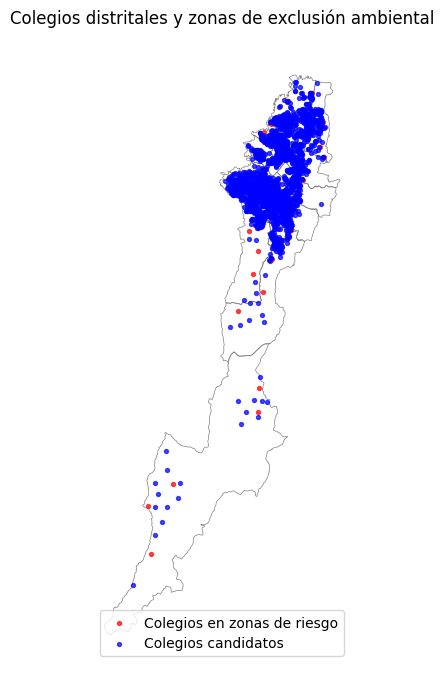

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

localidades.plot(
    ax=ax,
    edgecolor="gray",
    facecolor="none",
    linewidth=0.5
)

colegios_excluidos.plot(
    ax=ax,
    color="red",
    markersize=8,
    alpha=0.7,
    label="Colegios en zonas de riesgo"
)

colegios_seguro.plot(
    ax=ax,
    color="blue",
    markersize=8,
    alpha=0.7,
    label="Colegios candidatos"
)

ax.set_title("Colegios distritales y zonas de exclusión ambiental", fontsize=12)
ax.legend(loc="lower left")
ax.set_axis_off()

plt.show()

A continuación se seleccionan los colegios considerados seguros con demanda positiva como nodos del modelo, se limita el número máximo de instituciones para evitar problemas de memoria, se garantiza que todos tengan coordenadas espaciales y se construyen los vectores de coordenadas y demanda que servirán de insumo para el modelo de localización–asignación.

In [ ]:
import numpy as np

# Partimos de colegios seguros con demanda > 0
colegios_model = colegios_seguro[colegios_seguro["demanda"] > 0].copy()

print("Colegios seguros con demanda > 0:", len(colegios_model))

# Para no matar la RAM, si hay demasiados, nos quedamos con los de mayor demanda
max_n = 400  # puedes subir/bajar este número según lo que tolere tu Colab
if len(colegios_model) > max_n:
    colegios_model = (
        colegios_model
        .sort_values("demanda", ascending=False)
        .head(max_n)
        .copy()
    )
    print(f"Reducido a {len(colegios_model)} colegios para el modelo (mayor matrícula).")

# Reindexar limpio
colegios_model = colegios_model.reset_index(drop=True)

# Asegurarnos de tener coordenadas
if "x" not in colegios_model.columns or "y" not in colegios_model.columns:
    colegios_model["x"] = colegios_model.geometry.x
    colegios_model["y"] = colegios_model.geometry.y

coords = colegios_model[["x", "y"]].to_numpy()
demanda = colegios_model["demanda"].to_numpy()
N = len(colegios_model)

print("Número final de nodos en el modelo:", N)

Colegios seguros con demanda > 0: 2201
Reducido a 400 colegios para el modelo (mayor matrícula).
Número final de nodos en el modelo: 400


A continuación se definen como candidatos de planta los centroides de cada localidad, se calculan sus coordenadas y se construye la matriz de distancias euclídeas entre los colegios del modelo (nodos de demanda) y dichos candidatos, la cual se utilizará posteriormente en los modelos de localización.

In [ ]:
# Definir candidatos a planta como centroides de las localidades
candidatos_planta = gpd.GeoDataFrame(
    localidades[["Nombre_de_la_localidad"]].copy(),
    geometry=localidades.geometry.centroid,
    crs=localidades.crs
)

# Coordenadas de candidatos
candidatos_planta["x"] = candidatos_planta.geometry.x
candidatos_planta["y"] = candidatos_planta.geometry.y

# Coordenadas de demanda (colegios del modelo)
coords_dem = colegios_model[["x", "y"]].to_numpy()
coords_cand = candidatos_planta[["x", "y"]].to_numpy()

N_dem = coords_dem.shape[0]   # número de colegios (demanda)
N_cand = coords_cand.shape[0] # número de candidatos de planta

# Distancia euclídea demanda–candidato en metros usando broadcasting
dx = coords_dem[:, 0][:, None] - coords_cand[:, 0][None, :]
dy = coords_dem[:, 1][:, None] - coords_cand[:, 1][None, :]

dist_matrix_m = np.sqrt(dx**2 + dy**2)
dist_matrix_km = dist_matrix_m / 1000.0

print("Dimensiones matriz de distancias demanda–candidatos:", dist_matrix_km.shape)

Dimensiones matriz de distancias demanda–candidatos: (400, 20)


A continuación se formula y resuelve un modelo de localización tipo p-mediana donde los colegios del modelo actúan como nodos de demanda, los centroides de las localidades como candidatos a planta, la función objetivo minimiza la distancia total ponderada por la matrícula, y las restricciones garantizan que cada colegio se asigne a una única planta, que solo se asigne demanda donde efectivamente se ubica una planta y que se abran exactamente $\rho$ microplantas en el territorio.

In [ ]:
from pulp import (
    LpProblem, LpMinimize, LpVariable,
    lpSum, LpBinary, PULP_CBC_CMD, LpStatus
)

# Número de plantas que quieres ubicar (ajusta a tu gusto)
p = 1  # por ejemplo, 1 o 2 microplantas

prob = LpProblem("p_median_bogota_podas_colegios", LpMinimize)

# Conjuntos de índices
I = range(N_dem)    # demanda: colegios
J = range(N_cand)   # candidatos: centroides de localidades

# Variables binarias:
# y_j = 1 si instalamos planta en candidato j
y = LpVariable.dicts("y", J, lowBound=0, upBound=1, cat=LpBinary)

# x_ij = 1 si la demanda i se asigna a planta j
x = LpVariable.dicts("x", (I, J), lowBound=0, upBound=1, cat=LpBinary)

# --- Función objetivo ---
# minimizar suma_i suma_j [demanda_i * distancia_ij * x_ij]
prob += lpSum(
    demanda[i] * dist_matrix_km[i, j] * x[i][j]
    for i in I for j in J
), "Total_Weighted_Distance"

# --- Restricción 1: Cada colegio se asigna exactamente a 1 planta ---
for i in I:
    prob += lpSum(x[i][j] for j in J) == 1, f"asigna_demanda_{i}"

# --- Restricción 2: Solo puedes asignar a j si allí hay planta (x_ij <= y_j) ---
for i in I:
    for j in J:
        prob += x[i][j] <= y[j], f"asignacion_valida_{i}_{j}"

# --- Restricción 3: Se abren exactamente p plantas ---
prob += lpSum(y[j] for j in J) == p, "num_plantas"

# Resolver
solver = PULP_CBC_CMD(msg=True)
result_status = prob.solve(solver)

print("Status:", LpStatus[result_status])

Status: Optimal


Se identifican los centroides de localidad seleccionados por el modelo como sitios óptimos para la instalación de plantas, filtrando aquellos candidatos cuya variable de decisión toma valor cercano a uno; con estos índices se construye un subconjunto de localidades marcadas como “planta” y se reporta tanto el número de microplantas elegidas como el nombre de las localidades donde se ubicarían.

In [ ]:
# Índices de candidatos seleccionados
selected_idx = [j for j in J if y[j].value() > 0.75]
print("Índices de plantas seleccionadas (candidatos):", selected_idx)

planta_sites = candidatos_planta.iloc[selected_idx].copy()
planta_sites["es_planta"] = True

print("Número de plantas seleccionadas:", len(planta_sites))
planta_sites[["Nombre_de_la_localidad"]].head()

Índices de plantas seleccionadas (candidatos): [16]
Número de plantas seleccionadas: 1


,Nombre_de_la_localidad
16,CANDELARIA


Se genera una visualización cartográfica de los resultados del modelo p-mediana, utilizando las localidades de Bogotá como contexto territorial. Sobre este fondo se representan, en color azul, todos los colegios considerados en el modelo como nodos de demanda, y en color rojo los sitios seleccionados para la ubicación de las plantas (biodigestores). Esta representación permite apreciar de manera sintética cómo se distribuyen las instalaciones óptimas en relación con la red de colegios y el territorio distrital, facilitando la interpretación espacial de la solución obtenida.

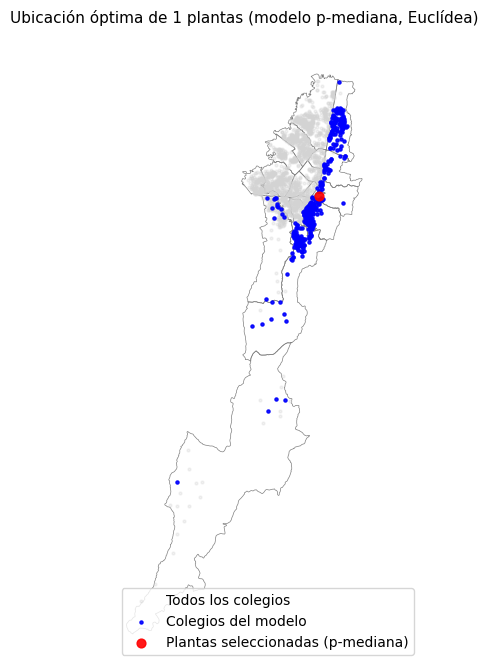

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Localidades de fondo
localidades.plot(
    ax=ax,
    edgecolor="gray",
    facecolor="none",
    linewidth=0.5
)

# TODOS los colegios (capa completa)
colegios.plot(
    ax=ax,
    markersize=4,
    alpha=0.3,
    color="lightgray",
    label="Todos los colegios"
)

# Solo los colegios usados en el modelo p-mediana
colegios_model.plot(
    ax=ax,
    markersize=5,
    alpha=0.9,
    color="blue",
    label="Colegios del modelo"
)

# Sitios de planta seleccionados
planta_sites.plot(
    ax=ax,
    markersize=40,
    alpha=0.9,
    color="red",
    label="Plantas seleccionadas (p-mediana)"
)

ax.set_title(
    f"Ubicación óptima de {len(planta_sites)} plantas (modelo p-mediana, Euclídea)",
    fontsize=11
)
ax.legend(loc="lower left")
ax.set_axis_off()

plt.show()

# Weber

In [ ]:
import numpy as np

# Extraer coordenadas y pesos desde el subconjunto que ya usas en p-mediana
coords = colegios_model[["x", "y"]].to_numpy()
weights = colegios_model["demanda"].to_numpy().astype(float)

print("N puntos de demanda en el modelo:", coords.shape[0])

def weiszfeld(coords, weights, x0=None, tol=1e-4, max_iter=500):
    """
    Implementación del algoritmo de Weiszfeld para la mediana geométrica ponderada
    (punto de Weber) en 2D con distancias euclídeas.
    """
    # Punto inicial: centroide ponderado
    if x0 is None:
        x = np.average(coords, axis=0, weights=weights)
    else:
        x = np.array(x0, dtype=float)

    for k in range(max_iter):
        # Distancias del punto actual a todos los puntos
        diff = coords - x
        dist = np.linalg.norm(diff, axis=1)

        # Si estamos demasiado cerca de uno de los puntos, devolvemos ese
        # (evita divisiones por cero y es solución válida)
        eps = 1e-12
        if np.any(dist < eps):
            idx = np.argmin(dist)
            return coords[idx], k, True  # True = coincidió con un punto de demanda

        # Fórmulas de Weiszfeld
        w_over_d = weights / dist
        num = np.sum((w_over_d[:, None]) * coords, axis=0)
        den = np.sum(w_over_d)

        x_new = num / den

        # Criterio de parada
        if np.linalg.norm(x_new - x) < tol:
            return x_new, k + 1, False

        x = x_new

    # Si no converge en max_iter, devolvemos lo último
    return x, max_iter, False

# Ejecutar Weiszfeld
weber_xy, n_iter, snapped = weiszfeld(coords, weights, tol=1e-4, max_iter=500)

print("Punto de Weber (x, y):", weber_xy)
print("Iteraciones:", n_iter)
print("¿Coincide exactamente con un colegio? ->", snapped)

# Calcular el valor de la función objetivo (distancia ponderada total)
dist_weber_m = np.linalg.norm(coords - weber_xy, axis=1)
dist_weber_km = dist_weber_m / 1000.0
obj_weber = np.sum(weights * dist_weber_km)

print(f"Distancia total ponderada (Weber, 1 planta): {obj_weber:,.2f} km·alumno")

N puntos de demanda en el modelo: 400
Punto de Weber (x, y): [998938.35204081 997342.78867336]
Iteraciones: 42
¿Coincide exactamente con un colegio? -> False
Distancia total ponderada (Weber, 1 planta): 3,897.22 km·alumno


In [ ]:
from shapely.geometry import Point
import geopandas as gpd

# Crear GeoDataFrame con el punto de Weber
weber_gdf = gpd.GeoDataFrame(
    {"metodo": ["Weber"], "geometry": [Point(weber_xy[0], weber_xy[1])]},
    crs=bogota_crs
)

# Ver en qué localidad cae (usando 'localidades' que ya cargaste de Bogota.gpkg)
weber_loc = gpd.sjoin(
    weber_gdf,
    localidades[["Nombre_de_la_localidad", "geometry"]],
    how="left",
    predicate="intersects"
)

weber_loc[["metodo", "Nombre_de_la_localidad", "geometry"]]

,metodo,Nombre_de_la_localidad,geometry
0,Weber,SAN CRISTOBAL,POINT (998938.352 997342.789)


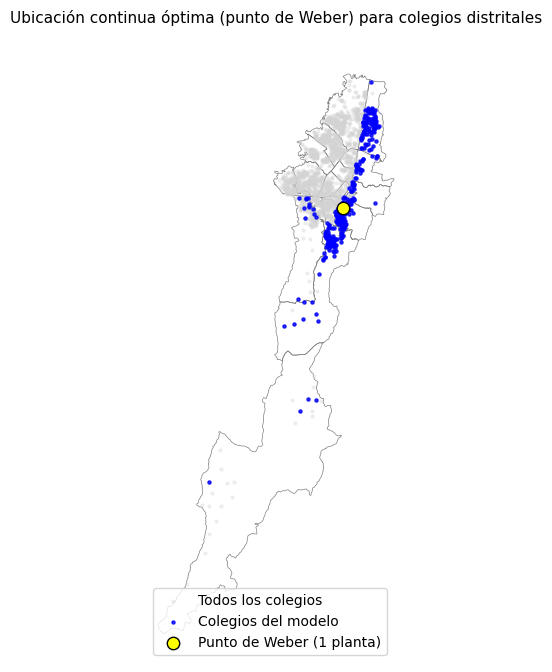

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# 1. Localidades de Bogotá como fondo
localidades.plot(
    ax=ax,
    edgecolor="gray",
    facecolor="none",
    linewidth=0.5
)

# 2. TODOS los colegios (capa completa)
colegios.plot(
    ax=ax,
    markersize=4,
    alpha=0.3,
    color="lightgray",
    label="Todos los colegios"
)

# 3. Colegios usados en el modelo (demanda)
colegios_model.plot(
    ax=ax,
    markersize=5,
    alpha=0.8,
    color="blue",
    label="Colegios del modelo"
)

# 4. Punto de Weber (1 planta continua)
try:
    weber_gdf.plot(
        ax=ax,
        markersize=80,
        color="yellow",
        edgecolor="black",
        label="Punto de Weber (1 planta)"
    )
except NameError:
    print("Aviso: 'weber_gdf' no está definido. Asegúrate de haber corrido la celda donde se calcula la solución de Weber.")

ax.set_title("Ubicación continua óptima (punto de Weber) para colegios distritales", fontsize=11)
ax.legend(loc="lower left")
ax.set_axis_off()

plt.show()

Usando 'colegios_seguro' (fuera de riesgo) como demanda.
Número de colegios con demanda > 0: 2201
Usando una muestra de 400 colegios como demanda para el MCLP.
Parámetros MCLP: p = 1, radio de cobertura = 2.0 km
Resolviendo MCLP...
Estado de la solución: Optimal
Demanda total cubierta (objetivo): 35.0
Número de plantas seleccionadas: 1
Demanda total       : 400.0
Demanda cubierta    : 35.0
Porcentaje cubierta : 8.75%


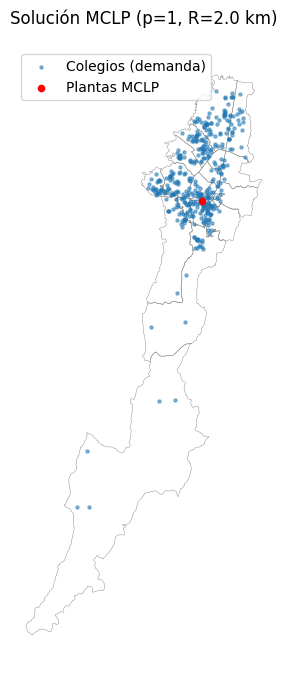

In [ ]:
import numpy as np
import pulp as pl
import matplotlib.pyplot as plt

# ============================
# 1. Elegir demanda y candidatos
# ============================

try:
    colegios_dem_raw = colegios_seguro.copy()
    print("Usando 'colegios_seguro' (fuera de riesgo) como demanda.")
except NameError:
    colegios_dem_raw = colegios.copy()
    print("No se encontró 'colegios_seguro'; usando 'colegios' completos como demanda.")

# Sólo nos quedamos con colegios que tengan demanda > 0
if "demanda" not in colegios_dem_raw.columns:
    raise ValueError("No se encontró columna 'demanda' en colegios. Asegúrate de haberla creado a partir de la matrícula.")

colegios_dem_raw = colegios_dem_raw[colegios_dem_raw["demanda"] > 0].copy()

print(f"Número de colegios con demanda > 0: {len(colegios_dem_raw)}")

# Muestra para no saturar RAM
max_demand_points = 400
if len(colegios_dem_raw) > max_demand_points:
    colegios_dem = colegios_dem_raw.sample(max_demand_points, random_state=42).reset_index(drop=True)
    print(f"Usando una muestra de {len(colegios_dem)} colegios como demanda para el MCLP.")
else:
    colegios_dem = colegios_dem_raw.reset_index(drop=True)
    print("Usando todos los colegios con demanda como demanda para el MCLP.")

# Candidatos: centroides de localidades (ya construidos en 'candidatos_planta')
cand_sites = candidatos_planta.copy()

# Índices
I = list(range(len(colegios_dem)))   # demanda (colegios)
J = list(range(len(cand_sites)))     # candidatos (plantas)

dem_w = colegios_dem["demanda"].to_numpy(dtype=float)

# ============================
# 2. Construir matriz de cobertura (distancias euclídeas en CRS proyectado)
# ============================

# Radio de cobertura en km (ajústalo según tu criterio)
R_km = 2.0

# Coordenadas en metros (EPSG:3116 es proyectado en metros)
dem_x = colegios_dem.geometry.x.to_numpy()
dem_y = colegios_dem.geometry.y.to_numpy()
cand_x = cand_sites.geometry.x.to_numpy()
cand_y = cand_sites.geometry.y.to_numpy()

# Distancias euclídeas (en metros) usando broadcasting de NumPy
dx = dem_x[:, None] - cand_x[None, :]
dy = dem_y[:, None] - cand_y[None, :]
dist_m = np.sqrt(dx**2 + dy**2)
dist_km = dist_m / 1000.0

# Matriz booleana de cobertura: True si dist_ij <= R_km
cover_matrix = dist_km <= R_km

# Para cada punto de demanda i, lista de candidatos que lo cubren
neighbors = {i: list(np.where(cover_matrix[i])[0]) for i in I}

# ============================
# 3. Parámetros del MCLP
# ============================

# Número de plantas a instalar
p = 1

print(f"Parámetros MCLP: p = {p}, radio de cobertura = {R_km} km")

# ============================
# 4. Modelo PuLP del MCLP
# ============================

prob = pl.LpProblem("MCLP_colegios_Bogota", pl.LpMaximize)

# Variables binarias:
# y_j = 1 si instalamos planta en candidato j
y = pl.LpVariable.dicts("y", J, lowBound=0, upBound=1, cat="Binary")
# x_i = 1 si demanda i está cubierta por al menos una planta en su vecindario
x = pl.LpVariable.dicts("x", I, lowBound=0, upBound=1, cat="Binary")

# Función objetivo: maximizar demanda cubierta
prob += pl.lpSum(dem_w[i] * x[i] for i in I), "Total_demanda_cubierta"

# Restricción: instalar exactamente p plantas
prob += pl.lpSum(y[j] for j in J) == p, "Num_plantas"

# Restricciones de cobertura: x_i <= sum_{j in N(i)} y_j
for i in I:
    if neighbors[i]:  # Si hay candidatos que cubren este punto de demanda
        prob += x[i] <= pl.lpSum(y[j] for j in neighbors[i]), f"coverage_{i}"
    else:
        # Nadie lo puede cubrir con este radio R_km -> x_i debe ser 0
        prob += x[i] == 0, f"no_coverage_{i}"

# ============================
# 5. Resolver modelo
# ============================

print("Resolviendo MCLP...")
prob.solve(pl.PULP_CBC_CMD(msg=False))

print("Estado de la solución:", pl.LpStatus[prob.status])
print("Demanda total cubierta (objetivo):", pl.value(prob.objective))

# ============================
# 6. Extraer plantas seleccionadas y demanda cubierta
# ============================

selected_plants_idx = [j for j in J if pl.value(y[j]) > 0.5]
plants_mclp = cand_sites.iloc[selected_plants_idx].copy()
plants_mclp["plant_id"] = range(1, len(plants_mclp) + 1)

covered_dem_idx = [i for i in I if pl.value(x[i]) > 0.5]
demanda_total = dem_w.sum()
demanda_cubierta = dem_w[covered_dem_idx].sum()

print(f"Número de plantas seleccionadas: {len(plants_mclp)}")
print(f"Demanda total       : {demanda_total:.1f}")
print(f"Demanda cubierta    : {demanda_cubierta:.1f}")
print(f"Porcentaje cubierta : {100 * demanda_cubierta / demanda_total:.2f}%")

plants_mclp.head()

fig, ax = plt.subplots(figsize=(8, 8))

# Localidades de fondo
localidades.plot(
    ax=ax,
    edgecolor="gray",
    facecolor="none",
    linewidth=0.3
)

# Puntos de demanda usados en el MCLP
colegios_dem.plot(
    ax=ax,
    markersize=5,
    alpha=0.5,
    label="Colegios (demanda)"
)

# Plantas seleccionadas por el MCLP
plants_mclp.plot(
    ax=ax,
    markersize=80,
    marker=".",
    color="red",
    label="Plantas MCLP"
)

ax.set_title(f"Solución MCLP (p={len(plants_mclp)}, R={R_km} km)", fontsize=12)
ax.set_axis_off()
ax.legend()

plt.show()

# AHP

In [ ]:
import numpy as np

# === 1. Centroides de localidades (candidatos) ===
localidades = localidades.copy()
localidades["centroid"] = localidades.geometry.centroid

# === 2. Usar los colegios "modelo" (seguros); si no existe, usar todos ===
try:
    _ = colegios_model
except NameError:
    colegios_model = colegios.copy()

# Asegurar que colegios_model tenga columna 'demanda'
if "demanda" not in colegios_model.columns:
    if "TMATRIC_GE" in colegios_model.columns:
        colegios_model["demanda"] = colegios_model["TMATRIC_GE"].fillna(0).astype(float)
    else:
        colegios_model["demanda"] = 1.0

def dist_media_ponderada(pt, destinos, pesos):
    d = destinos.distance(pt)
    if np.all(pesos.values == 0):
        return d.mean()
    return np.average(d, weights=pesos)

# Criterio C1: distancia media ponderada a colegios (menor = mejor)
localidades["dist_media_colegios"] = localidades["centroid"].apply(
    lambda p: dist_media_ponderada(p, colegios_model.geometry, colegios_model["demanda"])
)

# === 3. Criterio C2: seguridad ambiental (evitar riesgo) ===

def intersects_any(geom, gdf):
    # Si la capa viene vacía, devolvemos False
    if gdf is None or len(gdf) == 0:
        return False
    return gdf.intersects(geom).any()

# Booleans de riesgo por localidad
localidades["in_amenaza_mm"] = localidades.geometry.apply(
    lambda g: intersects_any(g, amenaza_mm)
)

localidades["in_amenaza_inun"] = localidades.geometry.apply(
    lambda g: intersects_any(g, amenaza_inun)
)

localidades["in_sist_hidrico"] = localidades.geometry.apply(
    lambda g: intersects_any(g, sist_hidrico)
)

localidades["in_ronda_hidraulica"] = localidades.geometry.apply(
    lambda g: intersects_any(g, ronda_hid)
)

# Número total de "riesgos" en los que cae cada localidad
localidades["n_riesgos"] = (
    localidades[[
        "in_amenaza_mm",
        "in_amenaza_inun",
        "in_sist_hidrico",
        "in_ronda_hidraulica"
    ]].sum(axis=1)
)

# Criterio C2: seguridad ambiental (1 = sin riesgo, 0 = mayor riesgo relativo)
max_riesgos = localidades["n_riesgos"].max()
if max_riesgos > 0:
    localidades["seguridad_ambiental"] = 1 - (localidades["n_riesgos"] / max_riesgos)
else:
    # Si ninguna localidad tiene riesgo, todas seguras (=1)
    localidades["seguridad_ambiental"] = 1.0

# Vista rápida de criterios crudos
localidades[[
    "Nombre_de_la_localidad",
    "dist_media_colegios",
    "n_riesgos",
    "seguridad_ambiental"
]].head()

,Nombre_de_la_localidad,dist_media_colegios,n_riesgos,seguridad_ambiental
0,BARRIOS UNIDOS,12771.299003,3,0.25
1,TEUSAQUILLO,11637.766240,3,0.25
2,PUENTE ARANDA,11386.156854,3,0.25
3,LOS MARTIRES,10450.616575,1,0.75
4,USAQUEN,17383.503828,4,0.00


In [ ]:
import numpy as np

def ahp_weights(pairwise_matrix):
    """
    Calcula pesos AHP a partir de una matriz de comparación por pares.
    Devuelve: vector de pesos y ratio de consistencia (CR).
    """
    M = np.array(pairwise_matrix, dtype=float)
    n = M.shape[0]

    # Autovalores y autovectores
    eigvals, eigvecs = np.linalg.eig(M)
    max_idx = eigvals.real.argmax()
    w = eigvecs[:, max_idx].real
    w = w / w.sum()

    # Consistency Index (CI) y Consistency Ratio (CR)
    lambda_max = eigvals.real[max_idx]
    CI = (lambda_max - n) / (n - 1) if n > 1 else 0.0

    # Índice aleatorio de Saaty (RI)
    RI_table = {1: 0.0, 2: 0.0, 3: 0.58, 4: 0.90, 5: 1.12,
                6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_table.get(n, 1.49)
    CR = CI / RI if RI > 0 else 0.0

    return w.real, CR

# === Matriz de comparación por pares para 2 criterios ===
# Orden: [C1 = distancia/proximidad colegios, C2 = seguridad ambiental]
# Ejemplo: C1 es "moderadamente más importante" que C2 -> valor 3
pairwise = [
    [1,   3],   # C1 vs C1, C1 vs C2
    [1/3, 1]    # C2 vs C1, C2 vs C2
]

weights, CR = ahp_weights(pairwise)

print("Pesos AHP (en el orden [C1_distancia, C2_seguridad]):", weights)
print("Ratio de consistencia (CR):", CR)

w_dist, w_seguridad = weights

Pesos AHP (en el orden [C1_distancia, C2_seguridad]): [0.75 0.25]
Ratio de consistencia (CR): 0.0


In [ ]:
# Copia para trabajar
loc_ahp = localidades.copy()

# --- Normalización del criterio C1: distancia a colegios (costo) ---
d = loc_ahp["dist_media_colegios"].astype(float)

if d.max() != d.min():
    # 1 = localidad más cercana (mejor), 0 = más lejana
    loc_ahp["score_distancia"] = (d.max() - d) / (d.max() - d.min())
else:
    loc_ahp["score_distancia"] = 1.0  # todas iguales

# --- Normalización del criterio C2: seguridad ambiental (beneficio) ---
s = loc_ahp["seguridad_ambiental"].astype(float)

if s.max() != s.min():
    loc_ahp["score_seguridad"] = (s - s.min()) / (s.max() - s.min())
else:
    loc_ahp["score_seguridad"] = 1.0

# --- Score final AHP (combinación lineal ponderada) ---
loc_ahp["score_AHP"] = (
    w_dist * loc_ahp["score_distancia"] +
    w_seguridad * loc_ahp["score_seguridad"]
)

# Ordenar de mejor a peor
loc_ahp_sorted = loc_ahp.sort_values("score_AHP", ascending=False)

loc_ahp_sorted[[
    "Nombre_de_la_localidad",
    "score_distancia",
    "score_seguridad",
    "score_AHP"
]].head(10)

,Nombre_de_la_localidad,score_distancia,score_seguridad,score_AHP
16,CANDELARIA,1.000000,1.000000,1.000000
3,LOS MARTIRES,0.995658,1.000000,0.996744
15,RAFAEL URIBE URIBE,0.994289,0.666667,0.912383
14,ANTONIO NARIÑO,0.998496,0.333333,0.832205
17,SAN CRISTOBAL,0.989594,0.333333,0.825529
2,PUENTE ARANDA,0.978652,0.333333,0.817322
1,TEUSAQUILLO,0.974078,0.333333,0.813892
6,SANTA FE,0.973678,0.333333,0.813592
12,TUNJUELITO,0.970261,0.333333,0.811029
5,CHAPINERO,0.959732,0.333333,0.803132


Localidad AHP óptima: CANDELARIA  | score_AHP = 1.0


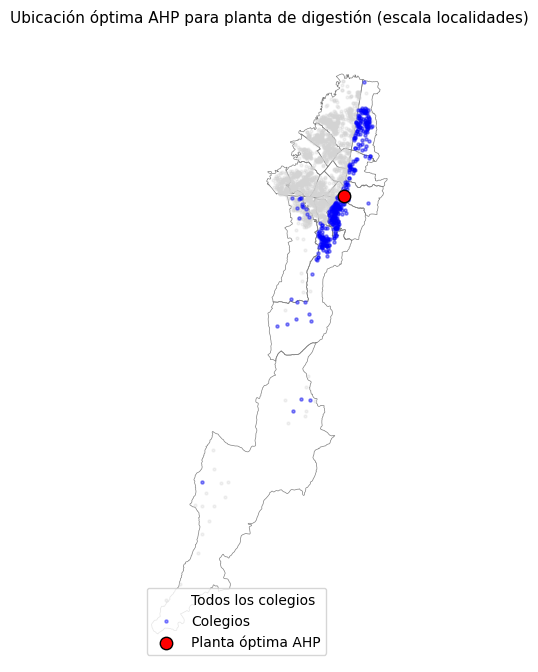

In [ ]:
# === Seleccionar la localidad óptima según AHP ===
# (la de mayor score_AHP)
loc_ahp_best = loc_ahp.loc[loc_ahp["score_AHP"].idxmax()].copy()

print("Localidad AHP óptima:",
      loc_ahp_best["Nombre_de_la_localidad"],
      " | score_AHP =",
      round(loc_ahp_best["score_AHP"], 3))

# Crear un GeoDataFrame con el punto óptimo (centroide de la localidad)
planta_ahp = gpd.GeoDataFrame(
    pd.DataFrame({
        "Nombre_de_la_localidad": [loc_ahp_best["Nombre_de_la_localidad"]],
        "score_AHP": [loc_ahp_best["score_AHP"]]
    }),
    geometry=[loc_ahp_best["centroid"]],
    crs=loc_ahp.crs
)

# Usar colegios_model si existe, si no, usamos colegios
try:
    _ = colegios_model
    colegios_plot = colegios_model
except NameError:
    colegios_plot = colegios

# === Mapa simple: localidades (contorno), colegios y punto óptimo AHP ===
fig, ax = plt.subplots(figsize=(8, 8))

# Localidades en contorno
localidades.plot(
    ax=ax,
    edgecolor="gray",
    facecolor="none",
    linewidth=0.5
)

colegios.plot(
    ax=ax,
    markersize=4,
    alpha=0.3,
    color="lightgray",
    label="Todos los colegios"
)

# Colegios (demanda)
colegios_plot.plot(
    ax=ax,
    markersize=5,
    alpha=0.4,
    color="blue",
    label="Colegios"
)

# Punto óptimo AHP
planta_ahp.plot(
    ax=ax,
    markersize=80,
    color="red",
    edgecolor="black",
    label="Planta óptima AHP"
)

ax.set_title("Ubicación óptima AHP para planta de digestión (escala localidades)", fontsize=11)
ax.legend(loc="lower left")
ax.set_axis_off()

plt.show()